I decided to treat this as a classification problem by creating a new binary
variable affair (did the woman have at least one affair?) and trying to
predict the classification for each woman.
Dataset
The dataset I chose is the affairs dataset that comes with Statsmodels. It
was derived from a survey of women in 1974 by Redbook magazine, in
which married women were asked about their participation in extramarital
affairs. More information about the study is available in a 1978 paper from
the Journal of Political Economy.
Description of Variables
The dataset contains 6366 observations of 9 variables:
rate_marriage: woman's rating of her marriage (1 = very poor, 5 =
very good)
age: woman's age
yrs_married: number of years married
children: number of children
religious: woman's rating of how religious she is (1 = not religious, 4 =
strongly religious)
educ: level of education (9 = grade school, 12 = high school, 14 =
some college, 16 = college graduate, 17 = some graduate school, 20
= advanced degree)
occupation: woman's occupation (1 = student, 2 = farming/semiskilled/unskilled, 3 = "white collar", 4 =
teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 =
professional with advanced degree)
occupation_husb: husband's occupation (same coding as above)
affairs: time spent in extra-marital affairs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

In [2]:
d = sm.datasets.fair.load_pandas()
df = d.data
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [3]:
def fun(x):
    if(x > 1):
        return 1
    else:
        return 0
    
df["affairs"] = df["affairs"].apply(fun) 
df.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affairs          6366 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 447.7 KB


In [5]:
df.isna().values.any()

False

In [6]:
# There are no NA values
df.isna().sum()

rate_marriage      0
age                0
yrs_married        0
children           0
religious          0
educ               0
occupation         0
occupation_husb    0
affairs            0
dtype: int64

In [7]:
df.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.175778
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,0.380661
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.000000
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,1.000000


In [8]:
df["affairs"].value_counts()

0    5247
1    1119
Name: affairs, dtype: int64

In [9]:
# We have binary classification 
# Dataset is imbalanced

print("% of 0: ", df["affairs"].value_counts().iloc[0] / len(df) * 100)
print("% of 1: ", df["affairs"].value_counts().iloc[1] / len(df) * 100)

% of 0:  82.42224316682375
% of 1:  17.57775683317625


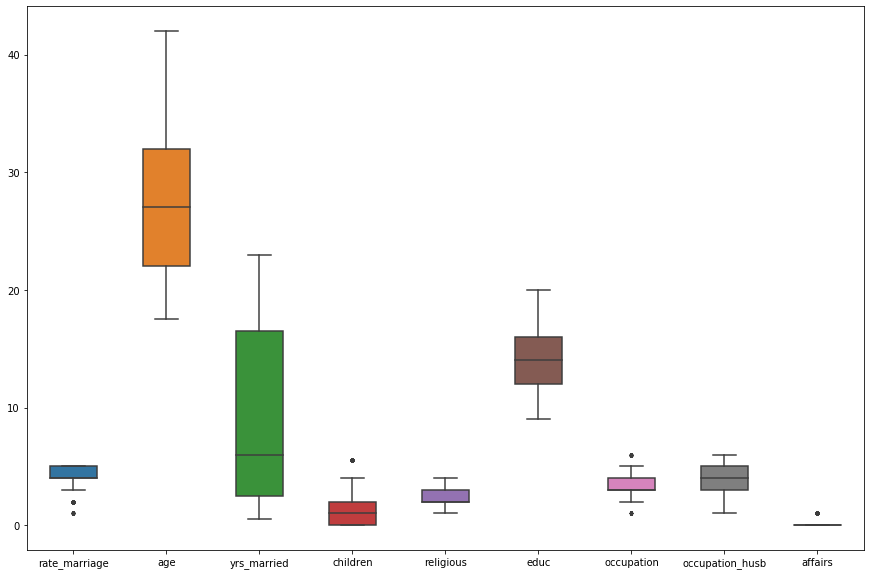

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=df, width= 0.5,ax=ax,  fliersize=3)

In [11]:
# Nr of children can't be 5.5 so we are going to replace it with 5
df["children"] = df["children"].replace(5.5, 5.0)

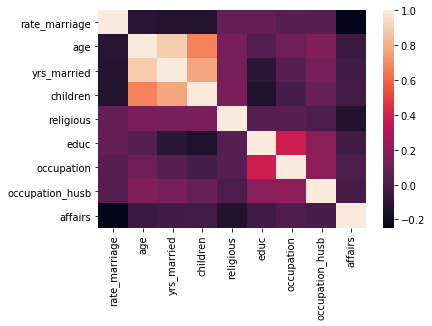

In [12]:
# There is a linear relationship between age, yrs_married.
sns.heatmap(df.corr())

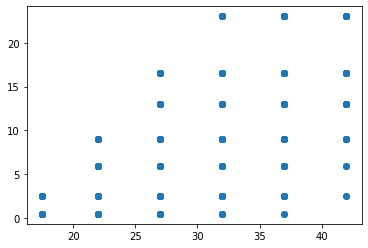

In [13]:
# There is a linear relationship between age and years married
plt.scatter(x=df["age"], y=df["yrs_married"])

In [14]:
# The pearson correlation coefficient is 0.89 so we must handle this multi colleniarity
df.corr()["age"]["yrs_married"]

0.8940818368147442

In [15]:
df["age_married"] = df["age"] - df["yrs_married"]

In [16]:
X = df.drop(columns = ['affairs'])
y = df['affairs']

In [17]:
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size = 0.25, random_state = 355, stratify=y)

# stratify=y to maintain the same percentage of data for each class at splitting in training and test

In [18]:
log_reg = LogisticRegression()

log_reg.fit(x_train,y_train)

LogisticRegression()

In [19]:
# Model performance in TRAINING SET (using threshold 0.5)

y_train_pred = log_reg.predict(x_train)

In [20]:
print(classification_report(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.83      0.99      0.90      3935
           1       0.44      0.05      0.09       839

    accuracy                           0.82      4774
   macro avg       0.64      0.52      0.49      4774
weighted avg       0.76      0.82      0.76      4774



In [21]:
# Our data is imbalanced so accuracy metric would not be a good way of evaluating the model
# In this case we use precision, recall, f1-score to evaluate the imbalanced dataset

accuracy = accuracy_score(y_train,y_train_pred)
accuracy

0.8221617092584834

In [22]:
y_train.value_counts()

0    3935
1     839
Name: affairs, dtype: int64

In [23]:
conf_mat = confusion_matrix(y_train,y_train_pred)
true_neg = conf_mat[0][0]
false_pos = conf_mat[0][1]
false_neg = conf_mat[1][0]
true_pos = conf_mat[1][1]

print("True Negative: ", conf_mat[0][0])
print("False Positive: ", conf_mat[0][1])
print("False Negative: ", conf_mat[1][0])
print("True Positive: ", conf_mat[1][1])

True Negative:  3885
False Positive:  50
False Negative:  799
True Positive:  40


In [24]:
# Overall accuracy of the model
acc = (true_pos + true_neg) / (true_pos + false_pos + false_neg + true_neg)
acc

0.8221617092584834

In [25]:
# Using precision, recall and f1 score  to verify how relevant is our model in positive results (1)
precision = true_pos / (true_pos + false_pos)
precision

0.4444444444444444

In [26]:
recall = true_pos / (true_pos + false_neg)
recall

0.04767580452920143

In [27]:
f1_score = 2*(recall * precision) / (recall + precision)
f1_score

# As we see, our model is not doing well in our positive results (affair=1)

0.08611410118406888

In [28]:
# Specifity or True Negative Rate
specifity = true_neg / (true_neg + false_pos)
specifity

# As we see, our model is not doing much well in our negative results (affair=0)

0.9872935196950444

In [29]:
# Model performance on TEST set

# First we must scale and apply PCA to test data
#x_test = pca.transform(x_test)
y_test_pred = log_reg.predict(x_test) # threshold is 0.5

y_test_pred_prob = log_reg.predict_proba(x_test)
y_test_pred_prob = y_test_pred_prob[:, 1]

In [30]:
# Model with threshold 0.5
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91      1312
           1       0.62      0.07      0.13       280

    accuracy                           0.83      1592
   macro avg       0.73      0.53      0.52      1592
weighted avg       0.80      0.83      0.77      1592



In [31]:
auc_test = roc_auc_score(y_test, y_test_pred_prob) # takes values from 0.5 to 1
auc_test

0.7043649281358885

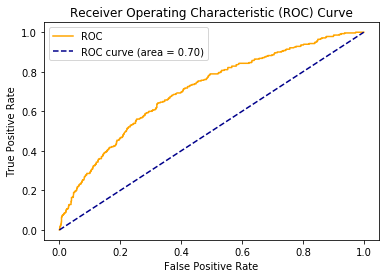

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc_test)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [33]:
# Since our dataset is imbalanced we must decrease the threshold to get better accuracy 

J_statistic = tpr - fpr
idx = np.argmax(J_statistic)
best_threshold = thresholds[idx]
print('Best Threshold=%f' % (best_threshold))

Best Threshold=0.182940


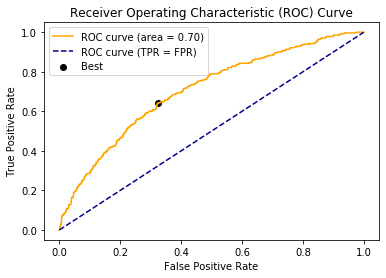

In [34]:
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (TPR = FPR)')
plt.scatter(fpr[idx], tpr[idx], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [35]:
pred = np.where(y_test_pred_prob > best_threshold, 1, 0)
pred

array([1, 1, 1, ..., 1, 0, 0])

In [36]:
# Model performance (with the best threshold) on TEST set

# Since our data is imbalanced, the best way to evaluate our model is to use f1-score
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.77      1312
           1       0.30      0.64      0.41       280

    accuracy                           0.67      1592
   macro avg       0.60      0.66      0.59      1592
weighted avg       0.79      0.67      0.71      1592



In [37]:
# from 283 positive rows, 209 were correctly classified
print(confusion_matrix(y_test, pred))

[[888 424]
 [101 179]]


In [38]:
import pickle
f1 = open("log_reg_model.pickle", "wb")
pickle.dump(log_reg, f1)

f2 = open("log_reg_threshold.sav", "wb")
pickle.dump(best_threshold, f2)

In [39]:
### Whenever we get TEST Data we make the predictions by our model following these steps : 

### We find the probability predictions using the model and select the probabilities of 1
# y_test_pred_prob = log_reg.predict_proba(x_test)
# y_test_pred_prob = y_test_pred_prob[:, 1]

### Using the threshold we find the predictions either 0 or 1 for each row
# pred = np.where(y_test_pred_prob > best_threshold, 1, 0)